# 影像增強,包含基本的開運算, 閉孕算, 高斯模糊, 梯度抓邊界等
# 根據影像的髒亂程度與後面用的ocr model 會有不同的影響,未必做了就會提升辨識準確度

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

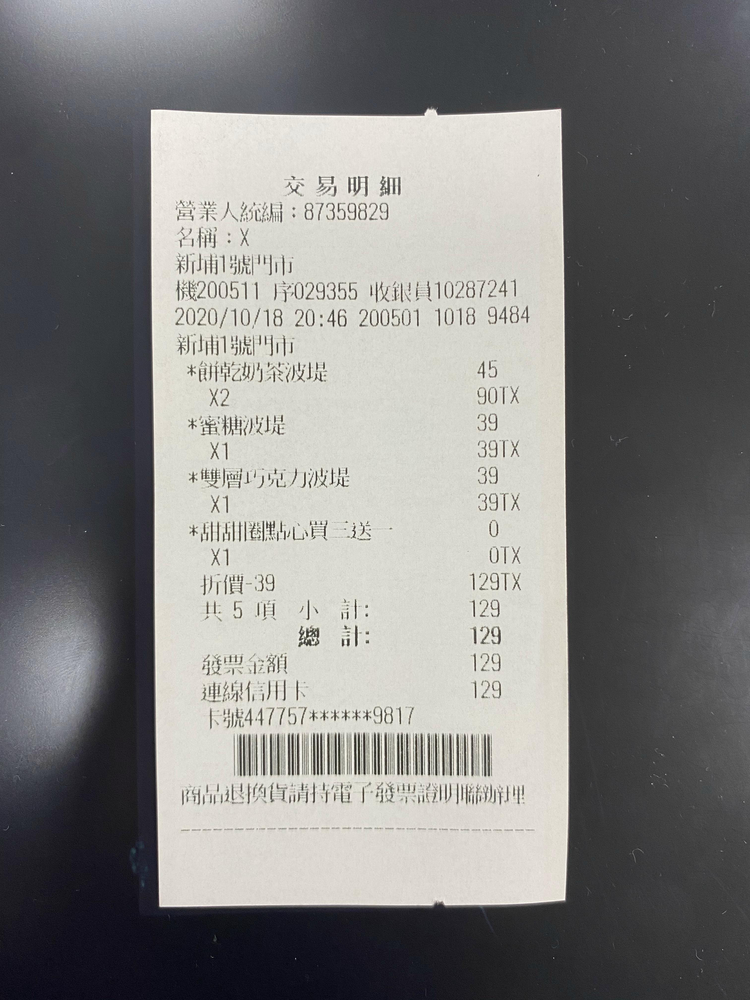

In [111]:
file_name = '/home/jacklee/ocr/image_data4/IMG_0788.HEIC.jpg'
img = Image.open(file_name)
img.thumbnail((1000,1000), Image.ANTIALIAS)
img

In [5]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [6]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [7]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [8]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio =500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

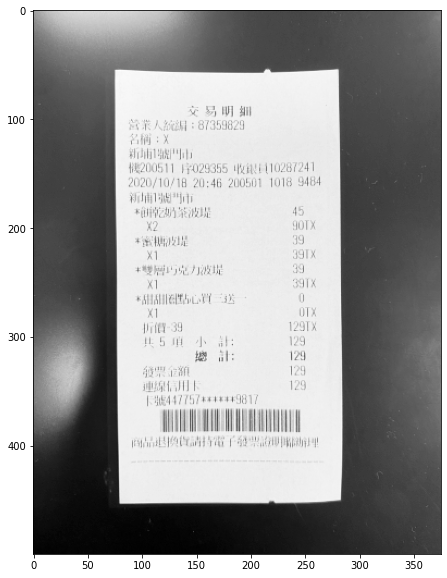

In [9]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

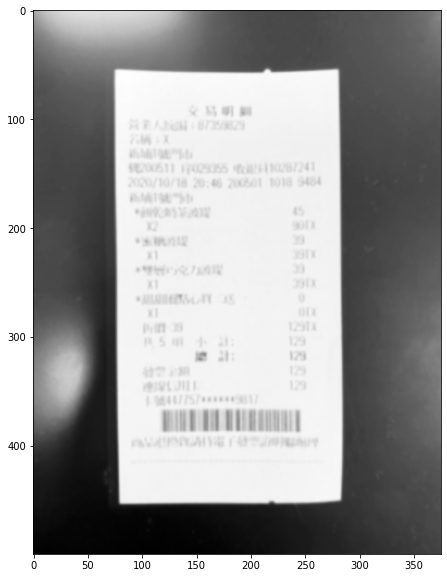

In [10]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

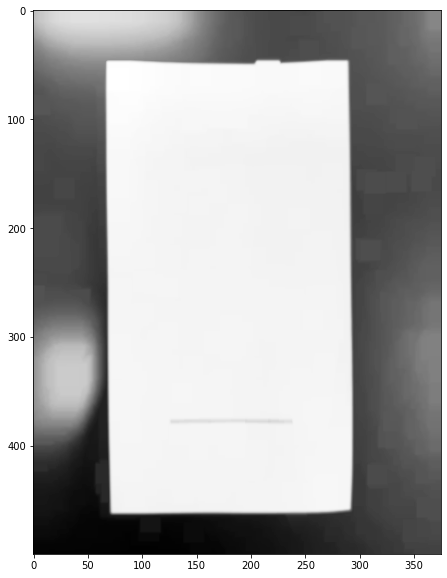

In [11]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

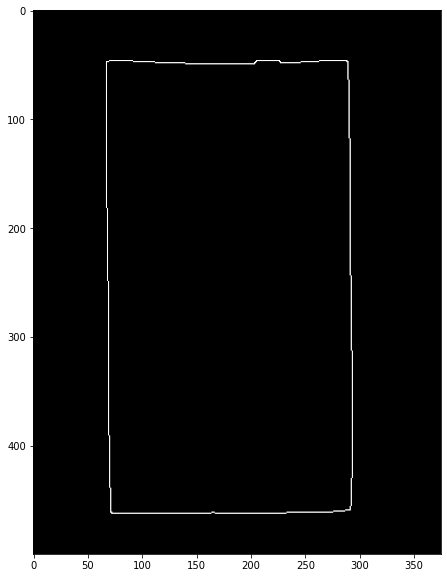

In [12]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

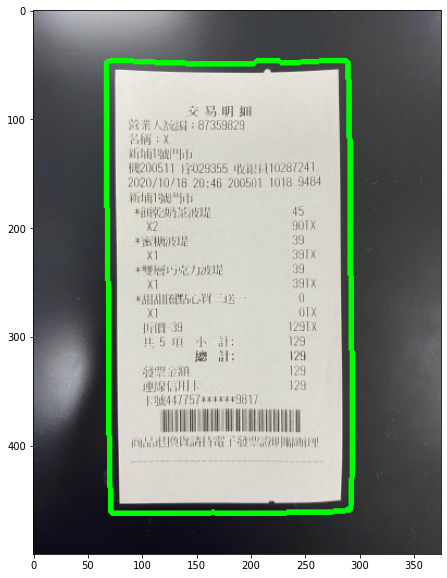

In [13]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

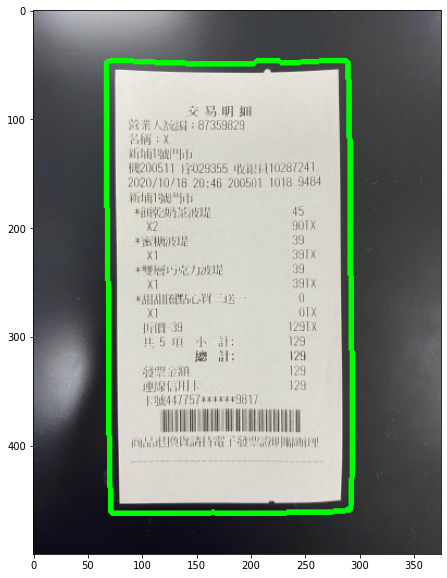

In [14]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [15]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [16]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
#         if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) >= 4:
            return approx

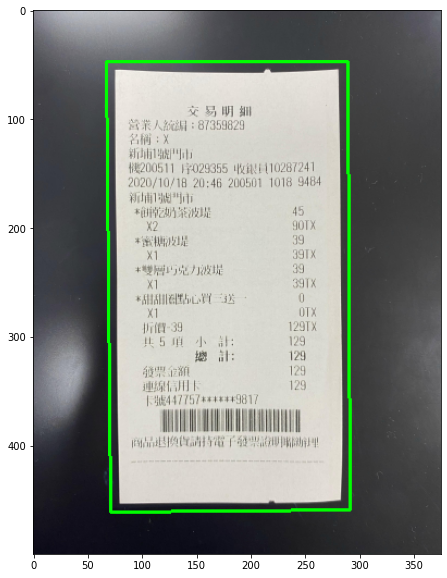

In [17]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [18]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [19]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

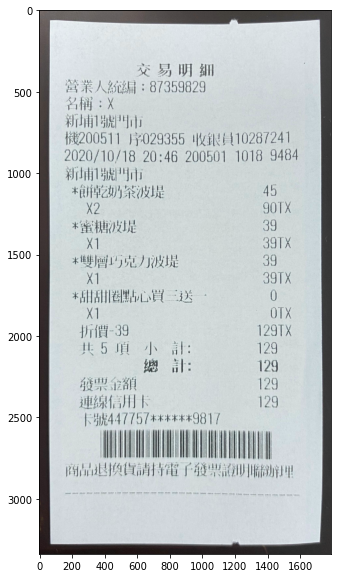

In [20]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [97]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 23, offset = 7, method = "gaussian")
    return (gray > T).astype("uint8") * 255

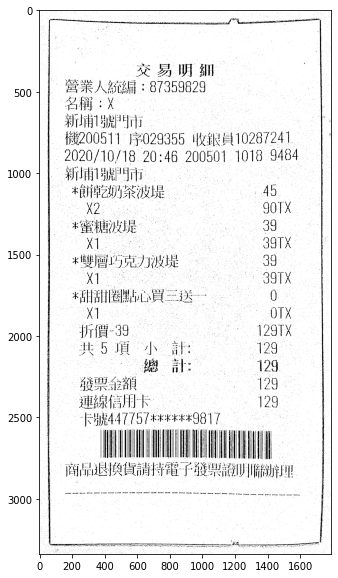

In [98]:
result = bw_scanner(scanned)
plot_gray(result)

In [99]:
# kernel = np.ones((2,2), np.uint8)

# #影象開運算
# result = cv2.erode(result, kernel, iterations = 1)
# # result = cv2.erode(result, kernel, iterations = 1)

In [100]:
# plot_gray(result)

In [101]:
# import matplotlib as plt
# from matplotlib import cm

# plt.image.imsave('result3.png', result,cmap = cm.gray)

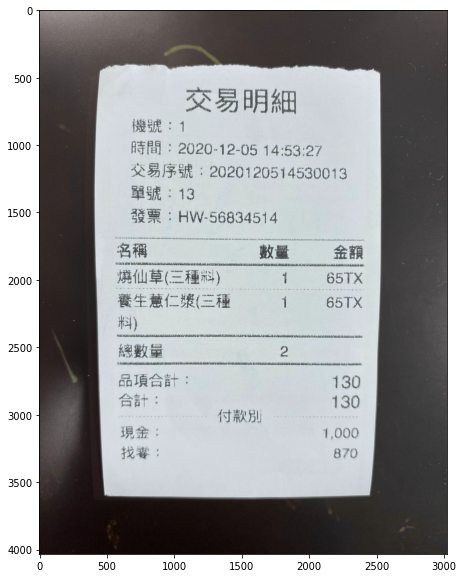

In [125]:
file_name = '/home/jacklee/ocr/image_data4/IMG_0790.HEIC.jpg'
image = cv2.imread(file_name)
plt.figure(figsize=(16,10))
plt.imshow(image)

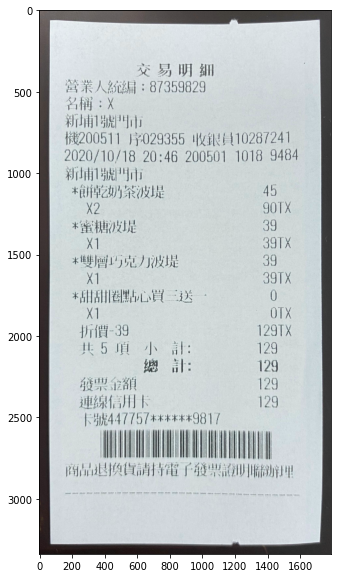

In [124]:
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [130]:
import easyocr
reader = easyocr.Reader(['ch_tra','en'])
text = reader.readtext(image, detail = 1)
text

[([[1055, 551], [1927, 551], [1927, 796], [1055, 796]],
  '交易明細',
  0.9004179239273071),
 ([[675, 792], [1097, 792], [1097, 927], [675, 927]],
  '機號: 1',
  0.5109066367149353),
 ([[666, 952], [921, 952], [921, 1091], [666, 1091]],
  '時間',
  0.9933359622955322),
 ([[1010, 960], [2113, 960], [2113, 1111], [1010, 1111]],
  '2020-12-05 14;53;2!',
  0.03281797468662262),
 ([[668, 1115], [1164, 1115], [1164, 1265], [668, 1265]],
  '交易序號',
  0.9860954880714417),
 ([[1243, 1131], [2300, 1131], [2300, 1279], [1243, 1279]],
  '2020120514530013',
  0.7002718448638916),
 ([[665, 1279], [1169, 1279], [1169, 1438], [665, 1438]],
  '單號 :13',
  0.24055050313472748),
 ([[665, 1449], [947, 1449], [947, 1599], [665, 1599]],
  '發票',
  0.6990399360656738),
 ([[1021, 1467], [1781, 1467], [1781, 1604], [1021, 1604]],
  'H1+-56834514',
  0.012985038571059704),
 ([[560, 1706], [816, 1706], [816, 1862], [560, 1862]],
  '8稱',
  0.3160591423511505),
 ([[1619, 1723], [1864, 1723], [1864, 1867], [1619, 1867]],
  '數

# 執行

In [131]:
file_name = '/home/jacklee/ocr/segmentation2.jpg'

In [1]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
#         if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) >= 4:
            return approx
def contour_to_rect(contour,resize_ratio):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio


def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 23, offset = 7, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')


In [2]:
def image_enhancement(file_name):
    image = cv2.imread(file_name)
    # Downscale image as finding receipt contour is more efficient on a small image
    resize_ratio = 500 / image.shape[0]
    original = image.copy()
    image = opencv_resize(image, resize_ratio)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Detect white regions
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
    dilated = cv2.dilate(blurred, rectKernel)
    edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
    # Detect all contours in Canny-edged image
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
    # Get 10 largest contours
    largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
    image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)

    receipt_contour = get_receipt_contour(largest_contours)
    image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
    scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour,resize_ratio))

    return scanned



In [3]:
from PIL import Image
import pyheif
import os
import matplotlib as plt
import cv2
import numpy as np

dirPath = '/home/jacklee/ocr/image_data4/'
outputdirPath = '/home/jacklee/ocr/image_data5/'
allFileList = os.listdir(dirPath)
for i in range(len(allFileList)):
    try:
        image_path = dirPath+allFileList[i]
        image_ouput_path = outputdirPath+allFileList[i]
        image = image_enhancement(image_path)
        cv2.imwrite(image_ouput_path,image)
    except:
        pass